# Neural Network Classification of Privacy Policy Data Practices

## August Karlstedt

Privacy policies 

.

.

.

.

.


ya

Let's start off by importing a bunch of libraries we'll need.

In [1]:
%matplotlib inline

import os
import imp
import operator
import math
import glob
import json
import time

from IPython.display import IFrame

import nltk
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#import pickle
#from six.moves import urllib

import tensorflow

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import LSTM, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras import metrics
from keras.utils.np_utils import to_categorical

#import fasttext
# https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md

import gensim
# https://nlp.stanford.edu/projects/glove/

Using TensorFlow backend.
c:\users\augustk\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load the Data

Load the annotation CSV files

In [2]:
files = []
data = []
header = ['Annotation ID', 'Batch ID', 'Annotator ID', 'Policy ID', 'Segment ID', 'Category Name', 'Attributes/Values', 'Policy URL', 'Date']
keep_columns = ['Segment ID', 'Category Name', 'Attributes/Values']
for file in glob.glob("data\\annotations/*.csv"):
    files.append(file[17:-4])
    data.append(pd.read_csv(file, names=header)[keep_columns])

Show some of the file names that we've loaded

In [3]:
files[:10]

['1017_sci-news.com',
 '1028_redorbit.com',
 '1034_aol.com',
 '1050_honda.com',
 '105_amazon.com',
 '1070_wnep.com',
 '1083_highgearmedia.com',
 '1089_freep.com',
 '1099_enthusiastnetwork.com',
 '1106_allstate.com']

Print how many files we've loaded (should be 115 since this is `OPP-115`:) and the length of the first file

In [4]:
print(len(data), len(data[0]))

115 58


Show an example of the data we've loaded from the annotations for the first file.

In [5]:
data[0]

,Segment ID,Category Name,Attributes/Values
0,0,Other,"{""Other Type"": {""selectedText"": ""Sci-News.com ..."
1,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati..."
2,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati..."
3,2,Data Retention,"{""Personal Information Type"": {""selectedText"":..."
4,3,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""Not sele..."
5,3,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""Not sele..."
6,3,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""Not sele..."
7,3,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""Not sele..."
8,4,International and Specific Audiences,"{""Audience Type"": {""selectedText"": ""Sci-News.c..."
9,4,Other,"{""Other Type"": {""selectedText"": ""Parents or gu..."


Now let's load the sanitized policies so we can extract the text from it later.

In [6]:
policies = []
for file in files:
    with open("data\\sanitized_policies/{}.html".format(file)) as f:
        policies.append(f.readlines()[0].split('|||'))

Print out some statistics about the policies as well as an example of the first one.

In [7]:
print(len(policies), len(policies[0]), policies[0])

115 13 ['Privacy Policy <br> <br> Sci-News.com is committed to protecting and respecting your privacy. To better inform you of our policy concerning user privacy, we have adopted the following terms. Please note that these terms are subject to change, and any such changes will be included on this page. <br> <br>', 'Information that Sci-News.com May Collect Online <br> <br> Sci-News.com may collect and process the following data about you: <br> <br> - information that you provide by filling in forms on our site, including names, e-mail and website addresses; we may also ask you for information for other purposes, for example when you report a problem with our site; <br> <br>', '- if you contact us, we may keep a record of that correspondence; <br> <br>', '- details of your visits to our site including, but not limited to, traffic data, location data, weblogs and other communication data. <br> <br>', 'Sci-News.com does not knowingly collect or solicit personal information from anyone und

Okay, so we have loaded our CSV files and also our privacy policies. Now we can use the CSV data to index into each segment in each privacy policy. Let's try this out manually for one privacy policy just to start.

In [8]:
test_file_index = 64
test_csv_file = data[test_file_index] # our table of attribute/values/categories/segment ids
test_pp_file = policies[test_file_index]
files[test_file_index]

'414_washingtonian.com'

Okay, let's load a single annotation and display the highlighted text in the privacy policy

In [9]:
test_row_num = 4

In [10]:
test_segment_id = test_csv_file['Segment ID'][test_row_num]
test_segment_id

2

In [11]:
test_category_name = test_csv_file['Category Name'][test_row_num]
test_category_name

'First Party Collection/Use'

Let's grab the attribute/value pairs, parse it, then inspect some stuff from there too.

In [12]:
test_attributes_values = json.loads(test_csv_file['Attributes/Values'][test_row_num])
test_attributes_values

{'Action First-Party': {'endIndexInSegment': 44,
  'selectedText': 'we collect',
  'startIndexInSegment': 34,
  'value': 'Unspecified'},
 'Choice Scope': {'endIndexInSegment': -1,
  'selectedText': 'Not selected',
  'startIndexInSegment': -1,
  'value': 'Unspecified'},
 'Choice Type': {'endIndexInSegment': -1,
  'selectedText': 'Not selected',
  'startIndexInSegment': -1,
  'value': 'Unspecified'},
 'Collection Mode': {'endIndexInSegment': -1,
  'selectedText': 'null',
  'startIndexInSegment': -1,
  'value': 'not-selected'},
 'Does/Does Not': {'endIndexInSegment': -1,
  'selectedText': 'null',
  'startIndexInSegment': -1,
  'value': 'Does'},
 'Identifiability': {'endIndexInSegment': -1,
  'selectedText': 'null',
  'startIndexInSegment': -1,
  'value': 'not-selected'},
 'Personal Information Type': {'endIndexInSegment': 56,
  'selectedText': 'include',
  'startIndexInSegment': 49,
  'value': 'Other'},
 'Purpose': {'endIndexInSegment': -1,
  'selectedText': 'Not selected',
  'startIndexI

In [13]:
test_attributes_values.keys()

dict_keys(['Does/Does Not', 'Action First-Party', 'Purpose', 'Personal Information Type', 'Identifiability', 'Choice Scope', 'User Type', 'Choice Type', 'Collection Mode'])

Let's get the annotation for `Personal Information Type` and see what the selected indices and text were

In [14]:
test_start_index = test_attributes_values['Personal Information Type']['startIndexInSegment']
test_end_index = test_attributes_values['Personal Information Type']['endIndexInSegment']
test_value = test_attributes_values['Personal Information Type']['value']
test_selected_text = test_attributes_values['Personal Information Type']['selectedText']
print(test_start_index, test_end_index, test_value, test_selected_text)

49 56 Other include


Just to verify, let's also grab the text directly from the policy itself to ensure the start/end indices work correctly.

In [15]:
test_pp_file[test_segment_id][test_start_index:test_end_index]

'include'

In [16]:
print("Segment ID: {}".format(test_segment_id))
print("Category Name: {}".format(test_category_name))
print("Type: {}".format('Personal Information Type'))
print("Value: {}".format(test_value))
print("Selected Text: {}".format(test_selected_text))

Segment ID: 2
Category Name: First Party Collection/Use
Type: Personal Information Type
Value: Other
Selected Text: include


Okay, a few things.

1. The text is already included in the CSV file. We don't necessarily need to index into the policy itself, unless we want to grab the entire sentence. Let's start by training the NN on *just* the selected text and not the whole sentence and see what we get.
2. The JSON in the `Attributes/Values` column has many different types. We need to grab them all so we know what to index into the dictionary for.
3. There's a value associated with each annotation OR it can be `Unspecified`

### Prepare the Data

Let's setup the categories that we'll try to classify. We'll also need one-hot encodings that for the network.

From the OPP paper https://www.usableprivacy.org/static/files/swilson_acl_2016.pdf:

1. **First Party Collection/Use**: how and why a service provider collects user information.
2. **Third Party Sharing/Collection**: how user information may be shared with or collected by third parties. 
3. **User Choice/Control**: choices and control options available to users. 
4. **User Access, Edit, & Deletion**: if and how users may access, edit, or delete their information. 
5. **Data Retention**: how long user information is stored. 
6. **Data Security**: how user information is protected. 
7. **Policy Change**: if and how users will be in formed about changes to the privacy policy. 
8. **Do Not Track**: if and how Do Not Track signals 3 for online tracking and advertising are honored. 
9. **International & Specific Audiences**: practices that pertain only to a specific group of users (e.g., children, Europeans, or California residents). 
10. **Other**: additional sublabels for introductory or general text, contact information, and practices not covered by the other categories.

In [17]:
# categories = set()
# for datum in data:
#     cat = datum['Category Name']
#     categories.update(cat)
# categories

categories = [
 'Data Retention', # 0
 'Data Security', # 1
 'Do Not Track', # 2
 'First Party Collection/Use', # 3
 'International and Specific Audiences', # 4
 'Other', # 5
 'Policy Change', # 6
 'Third Party Sharing/Collection', # 7
 'User Access, Edit and Deletion', # 8
 'User Choice/Control', # 9
 'None' # 10
]

one_hot_categories = np.array([
 [0,0,0,0,0,0,0,0,0,0,1],
 [0,0,0,0,0,0,0,0,0,1,0],
 [0,0,0,0,0,0,0,0,1,0,0],
 [0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,1,0,0,0,0],
 [0,0,0,0,0,1,0,0,0,0,0],
 [0,0,0,0,1,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0],
 [0,0,1,0,0,0,0,0,0,0,0],
 [0,1,0,0,0,0,0,0,0,0,0],
 [1,0,0,0,0,0,0,0,0,0,0],
])

cat_dict = {
 categories[0]:  one_hot_categories[0],
 categories[1]:  one_hot_categories[1],
 categories[2]:  one_hot_categories[2],
 categories[3]:  one_hot_categories[3],
 categories[4]:  one_hot_categories[4],
 categories[5]:  one_hot_categories[5],
 categories[6]:  one_hot_categories[6],
 categories[7]:  one_hot_categories[7],
 categories[8]:  one_hot_categories[8],
 categories[9]:  one_hot_categories[9],
 categories[10]: one_hot_categories[10],
}

Let's first get all of the Attributes/Values types to index into our dictionary. In the OPP-115 paper, Figure 1 looks like it shows the types on the right side.

In [18]:
# attribute_value_types = set()
# attribute_value_values = set()
# for datum in data:
#     avs = datum['Attributes/Values']
#     for row in avs:
#         parsed = json.loads(row)
#         keys = list(parsed.keys())
#         attribute_value_types.update(keys)
#         for key in keys:
#             attribute_value_values.add(parsed[key]['value'])

attribute_value_types = ['Access Scope',
 'Access Type',
 'Action First-Party',
 'Action Third Party',
 'Audience Type',
 'Change Type',
 'Choice Scope',
 'Choice Type',
 'Collection Mode',
 'Do Not Track policy',
 'Does/Does Not',
 'Identifiability',
 'Notification Type',
 'Other Type',
 'Personal Information Type',
 'Purpose',
 'Retention Period',
 'Retention Purpose',
 'Security Measure',
 'Third Party Entity',
 'User Choice',
 'User Type']

attribute_value_values = ['Additional service/feature',
 'Advertising',
 'Aggregated or anonymized',
 'Analytics/Research',
 'Basic service/feature',
 'Both',
 'Browser/device privacy controls',
 'Californians',
 'Children',
 'Citizens from other countries',
 'Collect from user on other websites',
 'Collect in mobile app',
 'Collect on first party website/app',
 'Collect on mobile website',
 'Collect on website',
 'Collection',
 'Computer information',
 'Contact',
 'Cookies and tracking elements',
 'Data access limitation',
 'Deactivate account',
 'Delete account (full)',
 'Delete account (partial)',
 'Demographic',
 'Does',
 'Does Not',
 'Dont use service/feature',
 'Edit information',
 'Europeans',
 'Explicit',
 'Export',
 'Financial',
 'First party collection',
 'First party use',
 'First-party privacy controls',
 'General notice in privacy policy',
 'General notice on website',
 'Generic',
 'Generic personal information',
 'Health',
 'Honored',
 'IP address and device IDs',
 'Identifiable',
 'Implicit',
 'In case of merger or acquisition',
 'Indefinitely',
 'Introductory/Generic',
 'Legal requirement',
 'Limited',
 'Location',
 'Marketing',
 'Mentioned, but unclear if honored',
 'Merger/Acquisition',
 'Named third party',
 'No notification',
 'Non-privacy relevant change',
 'None',
 'Not honored',
 'Not mentioned',
 'Opt-in',
 'Opt-out',
 'Opt-out link',
 'Opt-out via contacting company',
 'Other',
 'Other data about user',
 'Other part of company/affiliate',
 'Other users',
 'Perform service',
 'Personal identifier',
 'Personal notice',
 'Personalization/Customization',
 'Practice not covered',
 'Privacy contact information',
 'Privacy relevant change',
 'Privacy review/audit',
 'Privacy training',
 'Privacy/Security program',
 'Profile data',
 'Public',
 'Receive from other parts of company/affiliates',
 'Receive from other service/third-party (named)',
 'Receive from other service/third-party (unnamed)',
 'Receive/Shared with',
 'Secure data storage',
 'Secure data transfer',
 'Secure user authentication',
 'See',
 'Service Operation and Security',
 'Service operation and security',
 'Social media data',
 'Stated Period',
 'Survey data',
 'Third party sharing/collection',
 'Third party use',
 'Third-party privacy controls',
 'Track on first party website/app',
 'Track user on other websites',
 'Transactional data',
 'Unnamed third party',
 'Unspecified',
 'Use',
 'User Profile',
 'User account data',
 'User online activities',
 'User participation',
 'User profile',
 'User with account',
 'User without account',
 'View',
 'not-selected']

In [19]:
attribute_value_types

['Access Scope',
 'Access Type',
 'Action First-Party',
 'Action Third Party',
 'Audience Type',
 'Change Type',
 'Choice Scope',
 'Choice Type',
 'Collection Mode',
 'Do Not Track policy',
 'Does/Does Not',
 'Identifiability',
 'Notification Type',
 'Other Type',
 'Personal Information Type',
 'Purpose',
 'Retention Period',
 'Retention Purpose',
 'Security Measure',
 'Third Party Entity',
 'User Choice',
 'User Type']

In [20]:
attribute_value_values

['Additional service/feature',
 'Advertising',
 'Aggregated or anonymized',
 'Analytics/Research',
 'Basic service/feature',
 'Both',
 'Browser/device privacy controls',
 'Californians',
 'Children',
 'Citizens from other countries',
 'Collect from user on other websites',
 'Collect in mobile app',
 'Collect on first party website/app',
 'Collect on mobile website',
 'Collect on website',
 'Collection',
 'Computer information',
 'Contact',
 'Cookies and tracking elements',
 'Data access limitation',
 'Deactivate account',
 'Delete account (full)',
 'Delete account (partial)',
 'Demographic',
 'Does',
 'Does Not',
 'Dont use service/feature',
 'Edit information',
 'Europeans',
 'Explicit',
 'Export',
 'Financial',
 'First party collection',
 'First party use',
 'First-party privacy controls',
 'General notice in privacy policy',
 'General notice on website',
 'Generic',
 'Generic personal information',
 'Health',
 'Honored',
 'IP address and device IDs',
 'Identifiable',
 'Implicit',
 '

Okay, we have all of our attribute value types! Now, let's construct a dataframe of ALL of our data.

It should have columns: 

1. Paragraph2Vec representation of the text span
2. One hot representation of category

Unused data:
1. Segment index
2. Start index
3. End index
4. One hot representation of attribute
5. One hot representation of attribute type
6. One hot representation of attribute value


Setup the Doc2Vec model:

In [21]:
model = gensim.models.Doc2Vec(size=100)

Setup the Porter stemmer and WordNet Lemmatizer from NLTK

In [22]:
stemmer = nltk.stem.porter.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

Let's specify an array for the categories that we want to keep from the corpus. Right now, we keep all of them.

Additionally, we check for `remove_text` because of some annotation errors that occurred. If this text is detected, we can't use the selected text span for training since the text is invalid.

In [23]:
chosen_categories = ['First Party Collection/Use', 
                     'Third Party Sharing/Collection', 
                     'Other', 
                     'User Choice/Control', 
                     'Data Security',
                     'International and Specific Audiences',
                     'User Access, Edit and Deletion',
                     'Policy Change',
                     'Data Retention',
                     'Do Not Track',
                     'None' # added by us, not in original corpus
                    ]
remove_text = ['null', 'Not selected']

Ok, the main chunk of loading our data.

What's involved?

1. Iterate over all of the data which contains our annotations (per file)
2. For each annotation in the file, grab the `Category Name` that the annotation is associated with
3. If the `Category Name` is in our list of categories to keep, then
4. Parse the `Attributes/Values` pairs
5. Then, for each type of attribute, we retrieve the start/end indices and the selected text segment
6. We store the start/end indices to later determine a `None` category (described later)
7. We then do some preprocessing to the text: lowercase it and use NLTK's lemmatizer
8. Finally, we add this text to our Doc2Vec model to later be trained on.

In [24]:
df_columns = ['text', 'category', 'category one hot', 'text vec']
df = pd.DataFrame([], columns=df_columns)
series = []
documents = []
cats = []

remove_spans = {} # dictionary of policy ids and list of start, stop tuples that are then removed
# remove_spans structure:

'''
{
"2": --> this is the policy id
  {
   "6": [(20, 30), (30, 50)], --> this is the segment id
   "8": [(40, 123)] --> which maps to a list of tuple of start, end indices
  }
}
'''


idx = 0
for datum_idx in range(len(data)):
    datum = data[datum_idx]
    for idx in range(len(datum)):        
        category = datum['Category Name'][idx]
        
        if chosen_categories is None:
            continue
            
        if category not in chosen_categories:
            continue
        
        segment_id = datum['Segment ID'][idx]
        if datum_idx not in remove_spans:
            remove_spans[datum_idx] = {}
        if segment_id not in remove_spans[datum_idx]:
            remove_spans[datum_idx][segment_id] = []
            
        # ok, we have our policy text, now we need to 
        # remove all of the spans that are associated with a category
        # so we can attribute that text to the 'None' category
                
        parsed = json.loads(datum['Attributes/Values'][idx])
        for value in attribute_value_types:
            if value in parsed.keys():
                attributes = parsed[value]
                has_selected_text = 'selectedText' in attributes
                has_start_idx = 'startIndexInSegment' in attributes
                has_end_idx = 'endIndexInSegment' in attributes
                if has_selected_text and has_start_idx and has_end_idx:
                    text = attributes['selectedText']
                    start_idx = attributes['startIndexInSegment']
                    end_idx = attributes['endIndexInSegment']
                    
                    if text in remove_text or start_idx == -1 or end_idx == -1:
                        continue
                    
                    remove_spans[datum_idx][segment_id].append((start_idx, end_idx))
                    
                    text = text.lower()
                    processed_text = word_tokenize(text)
                    #processed_text = [stemmer.stem(word) for word in processed_text]
                    processed_text = [lemmatizer.lemmatize(word) for word in processed_text]
                    
                    doc = gensim.models.doc2vec.TaggedDocument(processed_text, [idx])
                    documents.append(doc)
                    cats.append(cat_dict[category])
                    text = ' '.join(processed_text)
                    series.append(pd.Series([text, category, cat_dict[category], None], index=df_columns))
                    
                    idx += 1

As mentioned in step 6 above, we now have to process the `None` spans!

We do so with the following steps:

1. Iterate through each policy
2. Iterate through each segment
3. Retrieve the text for the current policy/segment
4. Remove all of the start/end spans from the policy text that have been associated with a category
5. If we have any characters left, this is our `None` category, so we lemmatize this text and add it to our Doc2Vec model

In [25]:
replace_items = ["<br>", "<strong>", "</strong>", "<ul>", "</ul>", "<li>", "</li>", "<ol>", "</ol>"]
category = 'None'
none_count = 0
for policy_idx in remove_spans:
    policy = policies[policy_idx]
    for segment_idx in remove_spans[policy_idx]:
        try:
            policy_segment = policy[segment_idx]
        except IndexError as e:
            print(e, policy_idx, segment_idx)
            continue
        segment_text = policy_segment
        for span in remove_spans[policy_idx][segment_idx]:
            start_idx = span[0]
            end_idx = span[1]
            segment_text = segment_text[:start_idx] + " " + segment_text[end_idx:]
        segment_text = segment_text.lower()
        for item in replace_items:
            segment_text = segment_text.replace(item, " ")
        segment_text = segment_text.strip()
        if segment_text: # check if we have any characters at all
            processed_text = word_tokenize(segment_text)
            processed_text = [lemmatizer.lemmatize(word) for word in processed_text]

            doc = gensim.models.doc2vec.TaggedDocument(processed_text, [idx])
            documents.append(doc)
            cats.append(cat_dict[category])
            text = ' '.join(processed_text)
            series.append(pd.Series([text, category, cat_dict[category], None], index=df_columns))
            none_count += 1
            idx += 1
none_count

list index out of range 47 4
list index out of range 47 5
list index out of range 47 6
list index out of range 47 7
list index out of range 47 8
list index out of range 47 9
list index out of range 47 10
list index out of range 47 11
list index out of range 47 12
list index out of range 47 13
list index out of range 47 14
list index out of range 47 15
list index out of range 47 16
list index out of range 47 17
list index out of range 47 18
list index out of range 47 19
list index out of range 47 20
list index out of range 47 21
list index out of range 47 22
list index out of range 47 23
list index out of range 47 24
list index out of range 47 25
list index out of range 47 26
list index out of range 47 27
list index out of range 47 28
list index out of range 47 29
list index out of range 47 30
list index out of range 47 31
list index out of range 47 32
list index out of range 47 33
list index out of range 47 34
list index out of range 47 35
list index out of range 47 36
list index out o

1764

In [26]:
cats = np.array(cats)

Let's take a quick look at what our first and last documents look like

In [27]:
documents[0]

TaggedDocument(words=['sci-news.com', 'is', 'committed', 'to', 'protecting', 'and', 'respecting', 'your', 'privacy', '.', 'to', 'better', 'inform', 'you', 'of', 'our', 'policy', 'concerning', 'user', 'privacy', ',', 'we', 'have', 'adopted', 'the', 'following', 'term', '.', 'please', 'note', 'that', 'these', 'term', 'are', 'subject', 'to', 'change', ',', 'and', 'any', 'such', 'change', 'will', 'be', 'included', 'on', 'this', 'page', '.'], tags=[0])

In [28]:
documents[-1]

TaggedDocument(words=['you', 'may', 'also', 'contact', 'u', 'by', 'mail', 'using', 'the', 'address', 'below', '.'], tags=[1804])

And all of our data:

In [29]:
df = df.append(series, ignore_index=True)                    
df

,text,category,category one hot,text vec
0,sci-news.com is committed to protecting and re...,Other,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",None
1,sci-news.com may collect and process,First Party Collection/Use,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",None
2,nformation that you provide by filling in form...,First Party Collection/Use,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",None
3,including,First Party Collection/Use,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",None
4,"other purpose , for example when you report a ...",First Party Collection/Use,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",None
5,sci-news.com may collect and process,First Party Collection/Use,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",None
6,nformation that you provide by filling in form...,First Party Collection/Use,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",None
7,"name , e-mail and website address",First Party Collection/Use,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",None
8,"other purpose , for example when you report a ...",First Party Collection/Use,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",None
9,that correspondence,Data Retention,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",None


In [30]:
df.shape

(79670, 4)

Now let's build the vocab and train our Doc2Vec model!

In [31]:
model.build_vocab(documents)

In [32]:
model.train(documents, total_examples=len(documents), epochs=16)

12148047

Let's create a test to see what our Doc2Vec model outputs:

In [33]:
# setting model.random before infer_vector is required
# for determininistic behavior as described in 
# https://github.com/RaRe-Technologies/gensim/issues/447#issuecomment-138994654
model.random = np.random.RandomState(1234)
test_vec = model.infer_vector(word_tokenize('this is a test'))
print(test_vec.shape, '\n', test_vec)

(100,) 
 [-0.02253991 -0.03934259 -0.05766465  0.11670589  0.00363719 -0.06133116
  0.02281868  0.018267    0.11665507 -0.05863766  0.07950845 -0.01447559
  0.02238499 -0.00656394 -0.0188956  -0.04451303 -0.0454646   0.01586509
  0.04164188  0.02517026  0.03770122  0.0489611  -0.05523098  0.06578462
 -0.05367747  0.04341385  0.01755219 -0.03995054  0.00656469  0.03877796
 -0.01683516  0.03307758 -0.06074541  0.09064763 -0.14199974  0.02330392
  0.01135708 -0.03880553 -0.01291612 -0.09549323  0.05267145  0.0647653
  0.08166199  0.01646013 -0.00548129 -0.01776595 -0.04822004 -0.04341824
 -0.05591723 -0.08565143  0.02579061 -0.0473268   0.01321968  0.03251953
  0.04921448 -0.06332228 -0.0708748  -0.02993276  0.03131671 -0.0873818
 -0.06882058 -0.04630978 -0.02900856 -0.0535256  -0.05181774 -0.03984962
  0.01564511  0.06902116 -0.07662939  0.05144217 -0.08444939  0.08230814
  0.07647888  0.03520839  0.13791582  0.00675624 -0.04559606  0.00088278
 -0.09125112 -0.07115105 -0.0023873   0.0204

Ok, that looks good. Let's generate our vectors for every text span in our training data:

In [34]:
vecs = []
for row in df.itertuples():
    category_not_chosen = chosen_categories is None
    categorgy_chosen_and_matches = chosen_categories is not None and row.category in chosen_categories
    if categorgy_chosen_and_matches or category_not_chosen:
        model.random = np.random.RandomState(1234)
        vecs.append(np.array(model.infer_vector(word_tokenize(row.text))))
        
vecs = np.array(vecs)

In [35]:
vecs.shape

(79670, 100)

Since these Doc2Vec vectors are our only input data right now, let's just use them directly as our input data.

### Neural Network Setup

For now, we'll use a simple neural network consisting of:

1. **Fully connected** layer with 256 nodes, relu activation
2. **Dropout** 25% of the inputs
3. **Fully connected** layer with 256 nodes, relu activation
4. **Dropout** 25% of the inputs
5. **Fully connected** layer with 11 nodes, softmax activation

We use the Adam optimizer to perform gradient descent and categorical crossentropy as our loss function.

In [36]:
# Keras version
nn_model = Sequential()
nn_model.reset_states()
nn_model.add(Dense(256, batch_input_shape=(None, 100, ), activation='relu'))
nn_model.add(Dropout(0.25))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dropout(0.25))
nn_model.add(Dense(11, activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
nn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[metrics.mae, metrics.categorical_accuracy])
#nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics.mae, metrics.binary_accuracy])

print(nn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                2827      
Total params: 94,475
Trainable params: 94,475
Non-trainable params: 0
_________________________________________________________________
None


OK! Let's set our inputs as the Doc2Vec vectors and our targets as the one-hot encoded categories.

In [37]:
X_in = vecs
Y_in = cats
print(X_in.shape, Y_in.shape)

(79670, 100) (79670, 11)


If you have TensorBoard running, you'll see it in the IFrame below!

(With default settings, pointing to http://localhost:6006)

In [38]:
IFrame('http://localhost:6006', '100%', 800)

Train with 25% validation with mini batches of 128, for 128 epochs.

In [39]:
tensorboard_callback = TensorBoard(log_dir='C:/tmp/pp_run-'+time.strftime("%Y-%m-%d-%H%M%S"))
nn_model.fit(X_in, Y_in, validation_split=0.25, batch_size=128, epochs=128, verbose=1, callbacks=[tensorboard_callback])

Train on 59752 samples, validate on 19918 samples
Epoch 1/128
59752/59752 [==============================] - 5s 85us/step - loss: 1.3180 - mean_absolute_error: 0.1164 - categorical_accuracy: 0.4935 - val_loss: 1.9766 - val_mean_absolute_error: 0.1157 - val_categorical_accuracy: 0.4689
Epoch 2/128
59752/59752 [==============================] - 5s 82us/step - loss: 1.1961 - mean_absolute_error: 0.1084 - categorical_accuracy: 0.5368 - val_loss: 1.9822 - val_mean_absolute_error: 0.1133 - val_categorical_accuracy: 0.4966
Epoch 3/128
59752/59752 [==============================] - 5s 84us/step - loss: 1.1382 - mean_absolute_error: 0.1040 - categorical_accuracy: 0.5596 - val_loss: 2.0911 - val_mean_absolute_error: 0.1102 - val_categorical_accuracy: 0.5085
Epoch 4/128
59752/59752 [==============================] - 5s 81us/step - loss: 1.1004 - mean_absolute_error: 0.1012 - categorical_accuracy: 0.5748 - val_loss: 2.0250 - val_mean_absolute_error: 0.1088 - val_categorical_accuracy: 0.5141
Epoch 

59752/59752 [==============================] - 5s 81us/step - loss: 0.7535 - mean_absolute_error: 0.0729 - categorical_accuracy: 0.7084 - val_loss: 2.4535 - val_mean_absolute_error: 0.0995 - val_categorical_accuracy: 0.5317
Epoch 36/128
59752/59752 [==============================] - 5s 80us/step - loss: 0.7486 - mean_absolute_error: 0.0726 - categorical_accuracy: 0.7106 - val_loss: 2.4644 - val_mean_absolute_error: 0.0997 - val_categorical_accuracy: 0.5303
Epoch 37/128
59752/59752 [==============================] - 5s 82us/step - loss: 0.7500 - mean_absolute_error: 0.0724 - categorical_accuracy: 0.7106 - val_loss: 2.4625 - val_mean_absolute_error: 0.0999 - val_categorical_accuracy: 0.5306
Epoch 38/128
59752/59752 [==============================] - 5s 83us/step - loss: 0.7417 - mean_absolute_error: 0.0721 - categorical_accuracy: 0.7114 - val_loss: 2.4686 - val_mean_absolute_error: 0.0997 - val_categorical_accuracy: 0.5329
Epoch 39/128
59752/59752 [==============================] - 5s 83

Epoch 70/128
59752/59752 [==============================] - 5s 85us/step - loss: 0.6587 - mean_absolute_error: 0.0644 - categorical_accuracy: 0.7459 - val_loss: 2.5567 - val_mean_absolute_error: 0.0984 - val_categorical_accuracy: 0.5284
Epoch 71/128
59752/59752 [==============================] - 5s 82us/step - loss: 0.6586 - mean_absolute_error: 0.0644 - categorical_accuracy: 0.7440 - val_loss: 2.5548 - val_mean_absolute_error: 0.0992 - val_categorical_accuracy: 0.5257
Epoch 72/128
59752/59752 [==============================] - 5s 80us/step - loss: 0.6562 - mean_absolute_error: 0.0643 - categorical_accuracy: 0.7446 - val_loss: 2.5484 - val_mean_absolute_error: 0.0991 - val_categorical_accuracy: 0.5269
Epoch 73/128
59752/59752 [==============================] - 5s 78us/step - loss: 0.6512 - mean_absolute_error: 0.0639 - categorical_accuracy: 0.7471 - val_loss: 2.5658 - val_mean_absolute_error: 0.0990 - val_categorical_accuracy: 0.5302
Epoch 74/128
59752/59752 [==========================

59752/59752 [==============================] - 5s 86us/step - loss: 0.6090 - mean_absolute_error: 0.0599 - categorical_accuracy: 0.7628 - val_loss: 2.6253 - val_mean_absolute_error: 0.0981 - val_categorical_accuracy: 0.5258
Epoch 105/128
59752/59752 [==============================] - 5s 79us/step - loss: 0.6107 - mean_absolute_error: 0.0600 - categorical_accuracy: 0.7622 - val_loss: 2.6165 - val_mean_absolute_error: 0.0997 - val_categorical_accuracy: 0.5222
Epoch 106/128
59752/59752 [==============================] - 5s 83us/step - loss: 0.6066 - mean_absolute_error: 0.0598 - categorical_accuracy: 0.7621 - val_loss: 2.6150 - val_mean_absolute_error: 0.0980 - val_categorical_accuracy: 0.5249
Epoch 107/128
59752/59752 [==============================] - 5s 82us/step - loss: 0.6131 - mean_absolute_error: 0.0601 - categorical_accuracy: 0.7605 - val_loss: 2.6112 - val_mean_absolute_error: 0.0992 - val_categorical_accuracy: 0.5251
Epoch 108/128
59752/59752 [==============================] - 5

### Testing

Let's generate a confusion matrix to see the accuracy of our model.

First, just to get some stats on each category, the number of items in each:

In [40]:
for category in categories:
    print(len(df.loc[df['category'] == category]), 'examples in the', category, 'category')

942 examples in the Data Retention category
1008 examples in the Data Security category
90 examples in the Do Not Track category
37299 examples in the First Party Collection/Use category
937 examples in the International and Specific Audiences category
3544 examples in the Other category
1225 examples in the Policy Change category
25024 examples in the Third Party Sharing/Collection category
1691 examples in the User Access, Edit and Deletion category
6146 examples in the User Choice/Control category
1764 examples in the None category


To generate our confusion matrix, we need the indices

In [41]:
confusion_matrix_columns = categories

confusion_matrix = pd.DataFrame([], columns=confusion_matrix_columns)
confusion_matrix

,Data Retention,Data Security,Do Not Track,First Party Collection/Use,International and Specific Audiences,Other,Policy Change,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control,None


In [42]:
predictions = nn_model.predict(X_in)

for category in categories:
    row = pd.DataFrame([np.zeros(len(categories), dtype=np.int64)], columns=confusion_matrix_columns, index=[category])
    
    examples = df.loc[df['category'] == category]
    indices = examples.index
    
    pred = predictions[indices]
   
    for i in range(len(indices)):
        predicted_category = categories[np.argmax(np.round(pred[i]))]
        row[predicted_category] += 1
    
    confusion_matrix = confusion_matrix.append(row)

In [43]:
confusion_matrix

,Data Retention,Data Security,Do Not Track,First Party Collection/Use,International and Specific Audiences,Other,Policy Change,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control,None
Data Retention,228,9,9,113,1,6,2,303,0,8,263
Data Security,98,5,3,49,3,50,8,59,0,732,1
Do Not Track,10,1,0,2,1,2,0,11,62,1,0
First Party Collection/Use,3100,216,57,2388,3,108,73,31308,1,24,21
International and Specific Audiences,116,10,0,17,2,55,687,43,0,7,0
Other,410,59,19,133,41,2504,50,252,2,68,6
Policy Change,238,11,11,40,783,51,0,87,0,0,4
Third Party Sharing/Collection,2935,141,17,16334,4,81,9,5481,0,20,2
"User Access, Edit and Deletion",446,15,885,85,0,7,9,241,0,3,0
User Choice/Control,1645,2558,31,496,6,60,7,1339,0,3,1


In [44]:
confusion_matrix = confusion_matrix.infer_objects()

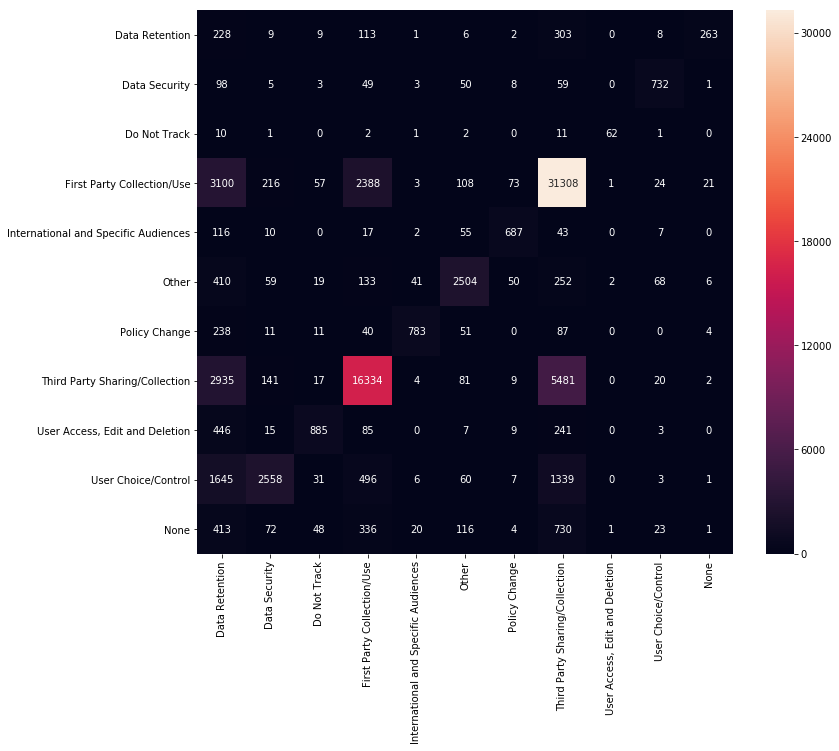

In [45]:
plt.figure(figsize = (12,10))
sn.heatmap(confusion_matrix, annot=True, fmt="d")